# **Model using IndoBERT Embedding** ≽^• ˕ • ྀི≼

## Data Balance ⋆🐾°

In [1]:
import torch

print("CUDA available? ", torch.cuda.is_available())        # True/False
print("Device count:   ", torch.cuda.device_count())        # misal: 1
if torch.cuda.is_available():
    print("Device name:   ", torch.cuda.get_device_name(0))


CUDA available?  True
Device count:    1
Device name:    NVIDIA A100-SXM4-40GB MIG 4g.20gb


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
import os, random, numpy as np, tensorflow as tf

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

2025-06-14 21:40:09.666713: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749912009.686980  195169 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749912009.693247  195169 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749912009.710076  195169 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749912009.710095  195169 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749912009.710097  195169 computation_placer.cc:177] computation placer alr

# Load IndoBERT Tokenizer

indobert_data.pkl → Hasil Tokenisasi IndoBERT

In [3]:
import pickle
from transformers import TFAutoModel

In [4]:
# Load IndoBERT tokenizer
with open('IndoBERT/Balance/indobert_tokenizer_data_balance.pkl', 'rb') as f:
    tokenizer_data = pickle.load(f)

tokenizer = tokenizer_data['tokenizer']

In [5]:
# Load data yang sudah di-tokenisasi dengan IndoBERT
with open('IndoBERT/Balance/indobert_data_balance.pkl', 'rb') as f:
    indobert_data = pickle.load(f)

X_train_ids = indobert_data['X_train_ids']
X_train_masks = indobert_data['X_train_masks']
X_val_ids = indobert_data['X_val_ids']
X_val_masks = indobert_data['X_val_masks']
X_test_ids = indobert_data['X_test_ids']
X_test_masks = indobert_data['X_test_masks']

y_train = indobert_data['y_train']
y_val = indobert_data['y_val']
y_test = indobert_data['y_test']
vocab_size = indobert_data['vocab_size']

### Load IndoBERT Embedding

In [8]:
with open('IndoBERT/Balance/indobert_large_embeddings_all_token_data_balance.pkl', 'rb') as f:
    emb_data = pickle.load(f)

X_train_embed = emb_data['X_train_embed']   # shape: (n_samples, embed_dim)
X_val_embed   = emb_data['X_val_embed']
X_test_embed  = emb_data['X_test_embed']
y_train       = emb_data['y_train']
y_val         = emb_data['y_val']
y_test        = emb_data['y_test']

In [9]:
print(X_train_embed.shape)

(1400, 128, 1024)


# Load Split Data

In [10]:
# Load kembali hasil split (teks asli)
from tensorflow.keras.utils import to_categorical

with open('IndoBERT/Balance/split_data_balance_model.pkl','rb') as f:
    split_data = pickle.load(f)

X_test_texts = split_data['X_test']   # ini harusnya Series atau list teks
y_test       = split_data['y_test']
y_test_cat   = split_data['y_test_cat'] if 'y_test_cat' in split_data else to_categorical(y_test)


# Model

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import f1_score

In [12]:
# Fungsi untuk memvisualisasikan hasil training
def plot_history(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title(f'{model_name} - Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper left')

    # Plot loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title(f'{model_name} - Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.savefig(f'{model_name}_training_history.png')
    plt.show()

In [13]:
# Membuat sentiment class names berdasarkan mapping
sentiment_classes = ['Neutral', 'Positive', 'Negative'] # 0, 1, 2

In [14]:
# Fungsi untuk menampilkan confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'{model_name}_confusion_matrix.png')
    plt.show()

In [15]:
# Fungsi untuk evaluasi model
def evaluate_model(model, X_input, y_test, y_test_cat, model_name, classes):
    """
    X_input bisa berupa:
      - array (X_test_ids / X_test_embed)
      - list: [X_test_ids, X_test_masks]
    """
    # Prediksi
    y_pred_proba = model.predict(X_input)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.argmax(y_test_cat, axis=1)

    # Classification report
    print(f"\nClassification Report - {model_name}:")
    print(classification_report(y_true, y_pred, target_names=classes))

    # F1 Scores
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    print(f"F1 Score (weighted): {f1_weighted:.4f}")
    print(f"F1 Score (macro)   : {f1_macro:.4f}")

    # Confusion Matrix
    plot_confusion_matrix(y_true, y_pred, classes, model_name)

    return {
        "f1_weighted": f1_weighted,
        "f1_macro": f1_macro,
        "y_pred": y_pred
    }

In [16]:
def save_predictions(raw_texts, y_true, y_pred, model_name):
    df = pd.DataFrame({
        'text': raw_texts.reset_index(drop=True),
        'true_label': y_true,
        'pred_label': y_pred
    })
    df['correct'] = df['true_label'] == df['pred_label']
    fname = f'{model_name}_predictions.xlsx'
    df.to_excel(fname, index=False)
    print(f'Saved predictions to Excel: {fname}')
    return df

## LSTM

In [49]:
import numpy as np
from transformers import TFAutoModel
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, BatchNormalization, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential
from keras.optimizers import Adam

In [56]:
# Reshape agar bisa dibaca LSTM
# embed_dim = X_train_embed.shape[1] 
X_train_input = X_train_embed       # shape (1400, 128, 1024)
X_val_input   = X_val_embed
X_test_input  = X_test_embed

# Jika label masih dalam bentuk integer, ubah ke one-hot
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)

num_classes = y_train_cat.shape[1]

# Parameter
# Ambil dari dimensi aslinya
seq_len     = X_train_input.shape[1]
embed_dim   = X_train_input.shape[2]
dropout_rate = 0.5
lstm_units = 64

In [57]:
# Callback
checkpoint = ModelCheckpoint('best_lstm_indobert_data_Balance.weights.h5', monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
callbacks = [checkpoint, reduce_lr]

# Model
lstm_model = Sequential([
    # Input(shape=(1, embed_dim)),
    Input(shape=(seq_len, embed_dim)),
    LSTM(lstm_units, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(dropout_rate),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(dropout_rate),
    Dense(num_classes, activation='softmax')
])

lstm_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
#lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
lstm_model.summary()

# Training
lstm_history = lstm_model.fit(
    X_train_input, y_train_cat,
    validation_data=(X_val_input, y_val_cat),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
)

# Load bobot terbaik yang sudah disimpan oleh ModelCheckpoint
lstm_model.load_weights('best_lstm_indobert_data_Balance.weights.h5')

# Simpan architecture sebagai JSON
with open('lstm_indobert_embed_best_architecture_data_Balance.json', 'w') as f:
    f.write(lstm_model.to_json())

print("Model berhasil disimpan")

# Sekarang model sudah berisi bobot terbaik, siap predict/evaluate
#val_pred_proba = lstm_model.predict(X_val_ids)
val_pred_proba = lstm_model.predict(X_val_input)
val_pred       = val_pred_proba.argmax(axis=1)
val_true       = y_val_cat.argmax(axis=1)


from sklearn.metrics import f1_score
print("Validation F1 (weighted):", f1_score(val_true, val_pred, average='weighted'))
print("Validation F1 (macro)   :", f1_score(val_true, val_pred, average='macro'))

# lstm_model.save('lstm_indobert_model.h5')

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 64)             │       278,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 281,219 (1.07 MB)

 Trainable params: 281,091 (1.07 MB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/50
42/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4209 - loss: 2.1009
Epoch 1: val_loss improved from inf to 1.23901, saving model to best_lstm_indobert_data_Balance.weights.h5
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.4252 - loss: 2.0881 - val_accuracy: 0.7333 - val_loss: 1.2390 - learning_rate: 0.0010
Epoch 2/50
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6586 - loss: 1.3762
Epoch 2: val_loss improved from 1.23901 to 1.10189, saving model to best_lstm_indobert_data_Balance.weights.h5
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6591 - loss: 1.3724 - val_accuracy: 0.7533 - val_loss: 1.1019 - learning_rate: 0.0010
Epoch 3/50
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7328 - loss: 1.1409
Epoch 3: val_loss improved from 1.10189 to 0.95404, saving model to best_lstm_indobert_data_Balance.weights.h5
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7333 - loss: 1.1412 - val_accuracy: 0.8200 - val_loss: 0.9540 - learning_rate: 0.0

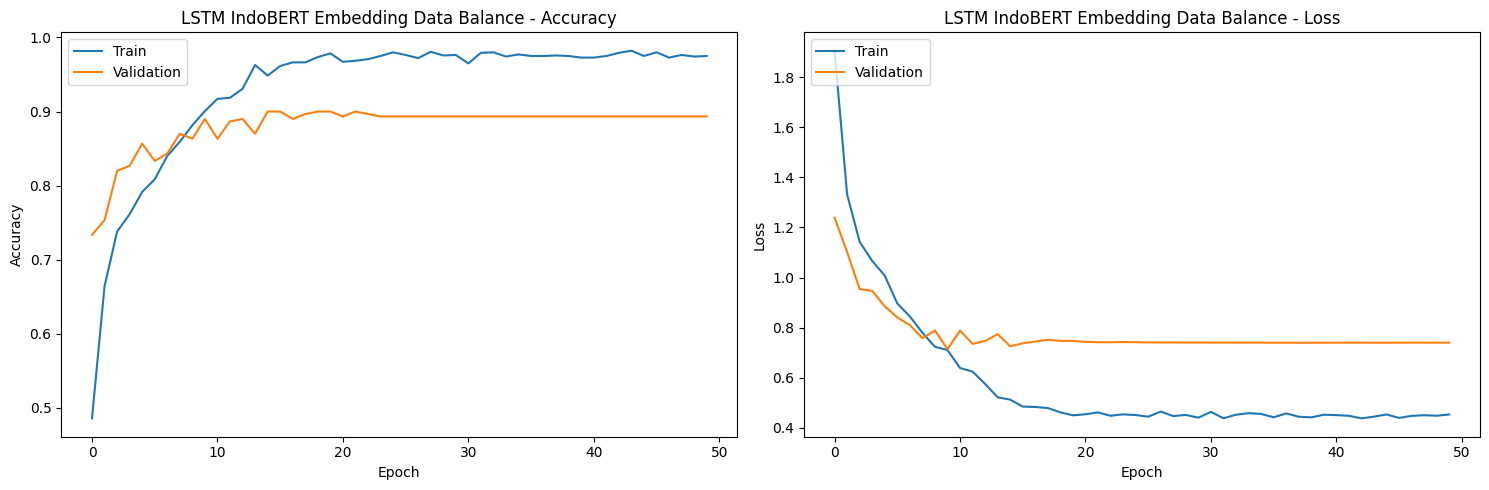

In [58]:
plot_history(lstm_history, 'LSTM IndoBERT Embedding Data Balance')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Classification Report - LSTM IndoBERT Embedding Model Data Balance:
              precision    recall  f1-score   support

     Neutral       0.89      0.85      0.87        94
    Positive       0.92      0.91      0.91        99
    Negative       0.90      0.94      0.92       107

    accuracy                           0.90       300
   macro avg       0.90      0.90      0.90       300
weighted avg       0.90      0.90      0.90       300

F1 Score (weighted): 0.9030
F1 Score (macro)   : 0.9019


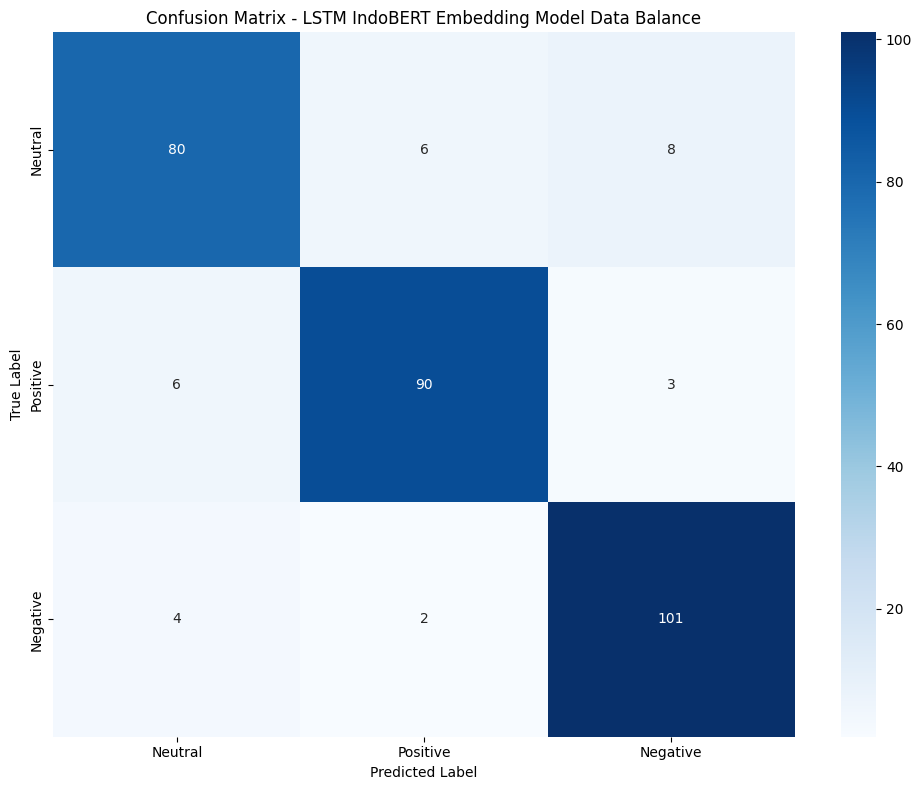

Saved predictions to Excel: LSTM_Model_IndoBERT_Data_Balance_predictions.xlsx


In [19]:
# Evaluasi model
results_lstm = evaluate_model(
    model       = lstm_model,
    X_input     = X_test_input,
    y_test      = y_test,
    y_test_cat  = y_test_cat,
    model_name  = "LSTM IndoBERT Embedding Model Data Balance",
    classes     = sentiment_classes
)

y_pred = results_lstm['y_pred']
y_true = np.argmax(y_test_cat, axis=1)

# Pastikan X_test_texts jadi Pandas Series
X_test_series = X_test_texts if isinstance(X_test_texts, pd.Series) else pd.Series(X_test_texts)

# Simpan prediksi
df_preds = save_predictions(
    raw_texts  = X_test_series,
    y_true     = y_true,
    y_pred     = y_pred,
    model_name = 'LSTM_Model_IndoBERT_Data_Balance'
)

## BiLSTM

In [27]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import numpy as np

In [29]:
# Reshape agar bisa dibaca BiLSTM, sama kayak sebelumnya
# embed_dim = X_train_embed.shape[1] 
X_train_input = X_train_embed      # shape: (n, seq_len, embed_dim)
X_val_input   = X_val_embed
X_test_input  = X_test_embed

# Ambil dimensi seq_len dan embed_dim dari data
seq_len   = X_train_input.shape[1]  # misal 128
embed_dim = X_train_input.shape[2]  # misal 1024

# Jika label masih dalam bentuk integer, ubah ke one-hot
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)

num_classes = y_train_cat.shape[1]
maxlen = X_train_input.shape[1]
dropout_rate = 0.5
# vocab_size = tokenizer.vocab_size + 1
# num_classes = len(np.unique(y_train))

In [30]:
# Callback
checkpoint = ModelCheckpoint(  
    'best_bilstm_indobert_data_Balance.weights.h5',  
    monitor='val_loss',  
    save_best_only=True,  
    save_weights_only=True,  
    verbose=1  
)  
reduce_lr = ReduceLROnPlateau(  
    monitor='val_loss',  
    factor=0.5,  
    patience=2,  
    min_lr=1e-6,  
    verbose=1  
)  
callbacks = [checkpoint, reduce_lr]

# Model BiLSTM
bilstm_model = Sequential([  
    # Input(shape=(1, embed_dim)),
    Input(shape=(seq_len, embed_dim)),  
    Bidirectional(LSTM(lstm_units, kernel_regularizer=l2(0.001))),  
    BatchNormalization(),  
    Dropout(dropout_rate),  
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),  
    Dropout(dropout_rate),  
    Dense(num_classes, activation='softmax')  
])

bilstm_model.compile(  
    optimizer='adam',  
    loss='categorical_crossentropy',  
    metrics=['accuracy']  
)  
bilstm_model.summary()

# Training  
bilstm_history = bilstm_model.fit(  
    X_train_input, y_train_cat,  
    validation_data=(X_val_input, y_val_cat),  
    epochs=50,  
    batch_size=32,  
    callbacks=callbacks,  
    verbose=1  
)

# Load best weights & save architecture
bilstm_model.load_weights('best_bilstm_indobert_data_Balance.weights.h5')  
with open('bilstm_indobert_embed_best_architecture_data_Balance.json', 'w') as f:  
    f.write(bilstm_model.to_json())

print("Model berhasil disimpan")

# Evaluate  
val_pred_proba = bilstm_model.predict(X_val_input)  
val_pred       = val_pred_proba.argmax(axis=1)  
val_true       = y_val_cat.argmax(axis=1)

print("Validation F1 (weighted):", f1_score(val_true, val_pred, average='weighted'))  
print("Validation F1 (macro)   :", f1_score(val_true, val_pred, average='macro'))

# bilstm_model.save('bilstm_indobert_model.h5')

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 128)            │       557,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 562,307 (2.15 MB)

 Trainable params: 562,051 (2.14 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/50
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4988 - loss: 2.4512
Epoch 1: val_loss improved from inf to 1.50338, saving model to best_bilstm_indobert_data_Balance.weights.h5
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5070 - loss: 2.4202 - val_accuracy: 0.8100 - val_loss: 1.5034 - learning_rate: 0.0010
Epoch 2/50
41/44 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6983 - loss: 1.7258
Epoch 2: val_loss improved from 1.50338 to 1.46460, saving model to best_bilstm_indobert_data_Balance.weights.h5
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7006 - loss: 1.7199 - val_accuracy: 0.7533 - val_loss: 1.4646 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7834 - loss: 1.4500
Epoch 3: val_loss improved from 1.46460 to 1.28187, saving model to best_bilstm_indobert_data_Balance.weights.h5
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7836 - loss: 1.4490 - val_accuracy: 0.8500 - val_loss: 1.2819 - learning_rat

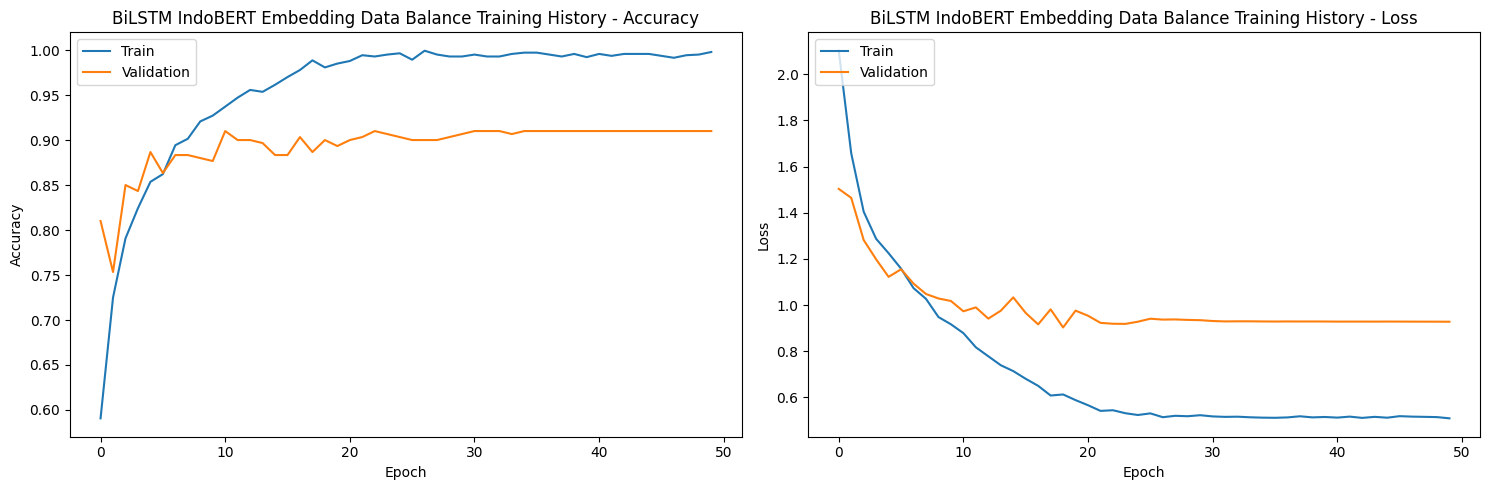

In [31]:
plot_history(bilstm_history, 'BiLSTM IndoBERT Embedding Data Balance Training History')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Classification Report - BiLSTM IndoBERT Embedding Model Data Balance:
              precision    recall  f1-score   support

     Neutral       0.86      0.85      0.86        94
    Positive       0.93      0.89      0.91        99
    Negative       0.92      0.96      0.94       107

    accuracy                           0.90       300
   macro avg       0.90      0.90      0.90       300
weighted avg       0.90      0.90      0.90       300

F1 Score (weighted): 0.9030
F1 Score (macro)   : 0.9012


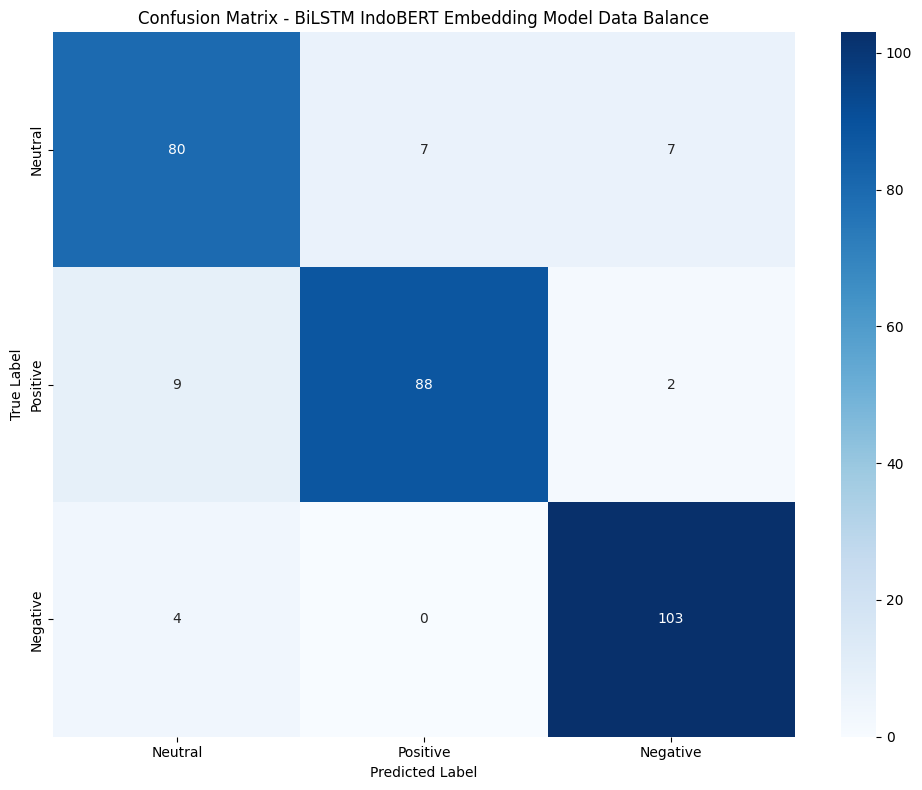

Saved predictions to Excel: BiLSTM_Model_IndoBERT_Data_Balance_predictions.xlsx


In [24]:
# Evaluasi model
results_bilstm = evaluate_model(
    model       = bilstm_model,
    X_input     = X_test_input,
    y_test      = y_test,
    y_test_cat  = y_test_cat,
    model_name  = "BiLSTM IndoBERT Embedding Model Data Balance",
    classes     = sentiment_classes
)

y_pred = results_bilstm['y_pred']
y_true = np.argmax(y_test_cat, axis=1)

# Pastikan X_test_texts jadi Pandas Series
X_test_series = X_test_texts if isinstance(X_test_texts, pd.Series) else pd.Series(X_test_texts)

# Simpan prediksi
df_preds = save_predictions(
    raw_texts  = X_test_series,
    y_true     = y_true,
    y_pred     = y_pred,
    model_name = 'BiLSTM_Model_IndoBERT_Data_Balance'
)

## CNN

In [59]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import numpy as np

In [82]:
X_train_input = X_train_embed      # shape: (n, seq_len, embed_dim)
X_val_input   = X_val_embed
X_test_input  = X_test_embed

# Ambil dimensi seq_len dan embed_dim dari data
seq_len   = X_train_input.shape[1]  # misal 128
embed_dim = X_train_input.shape[2]  # misal 1024

# One-hot encode label
y_train_cat = to_categorical(y_train)
y_val_cat   = to_categorical(y_val)
y_test_cat  = to_categorical(y_test)
num_classes = y_train_cat.shape[1]

dropout_rate = 0.5

In [ ]:
# Callbacks
# early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint(
    'best_cnn_indobert_data_Balance.weights.h5',
    monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1
)
callbacks = [checkpoint, reduce_lr]

# CNN Model
# input_layer = Input(shape=(1, embed_dim), name='input_emb')
input_layer = Input(shape=(seq_len, embed_dim), name='input_emb')
conv        = Conv1D(filters=128, kernel_size=1, activation='relu', kernel_regularizer=l2(0.001))(input_layer)
bn          = BatchNormalization()(conv)
pool        = GlobalMaxPooling1D()(bn)
drop1       = Dropout(dropout_rate)(pool)
dense       = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(drop1)
drop2       = Dropout(dropout_rate)(dense)
output      = Dense(num_classes, activation='softmax')(drop2)

cnn_model = Model(inputs=input_layer, outputs=output)
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

# Train
cnn_history = cnn_model.fit(
    X_train_input, y_train_cat,
    validation_data=(X_val_input, y_val_cat),
    epochs=50, batch_size=32, callbacks=callbacks, verbose=1
)

# Simpan model
cnn_model.load_weights('best_cnn_indobert_data_Balance.weights.h5')
with open('cnn_indobert_embed_best_architecture_data_Balance.json', 'w') as f:
    f.write(cnn_model.to_json())
print("Model berhasil disimpan")

# Evaluate
val_pred_proba = cnn_model.predict(X_val_input)
val_pred       = val_pred_proba.argmax(axis=1)
val_true       = y_val_cat.argmax(axis=1)
print("Validation F1 (weighted):", f1_score(val_true, val_pred, average='weighted'))
print("Validation F1 (macro)   :", f1_score(val_true, val_pred, average='macro'))

# cnn_model.save('cnn_indobert_model.h5')

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_emb (InputLayer)          │ (None, 128, 1024)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (None, 128, 128)       │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 128, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_21         │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 140,163 (547.51 KB)

 Trainable params: 139,907 (546.51 KB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4095 - loss: 3.7627
Epoch 1: val_loss improved from inf to 1.32977, saving model to best_cnn_indobert_data_Balance.weights.h5
44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - accuracy: 0.4107 - loss: 3.7373 - val_accuracy: 0.4833 - val_loss: 1.3298 - learning_rate: 0.0010
Epoch 2/50
36/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5771 - loss: 1.3868
Epoch 2: val_loss improved from 1.32977 to 1.08912, saving model to best_cnn_indobert_data_Balance.weights.h5
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5769 - loss: 1.3815 - val_accuracy: 0.6433 - val_loss: 1.0891 - learning_rate: 0.0010
Epoch 3/50
43/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6429 - loss: 1.1853
Epoch 3: val_loss improved from 1.08912 to 0.92760, saving model to best_cnn_indobert_data_Balance.weights.h5
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6432 - loss: 1.1837 - val_accuracy: 0.8100 - val_loss: 0.9276 - learning_rate: 0.0010


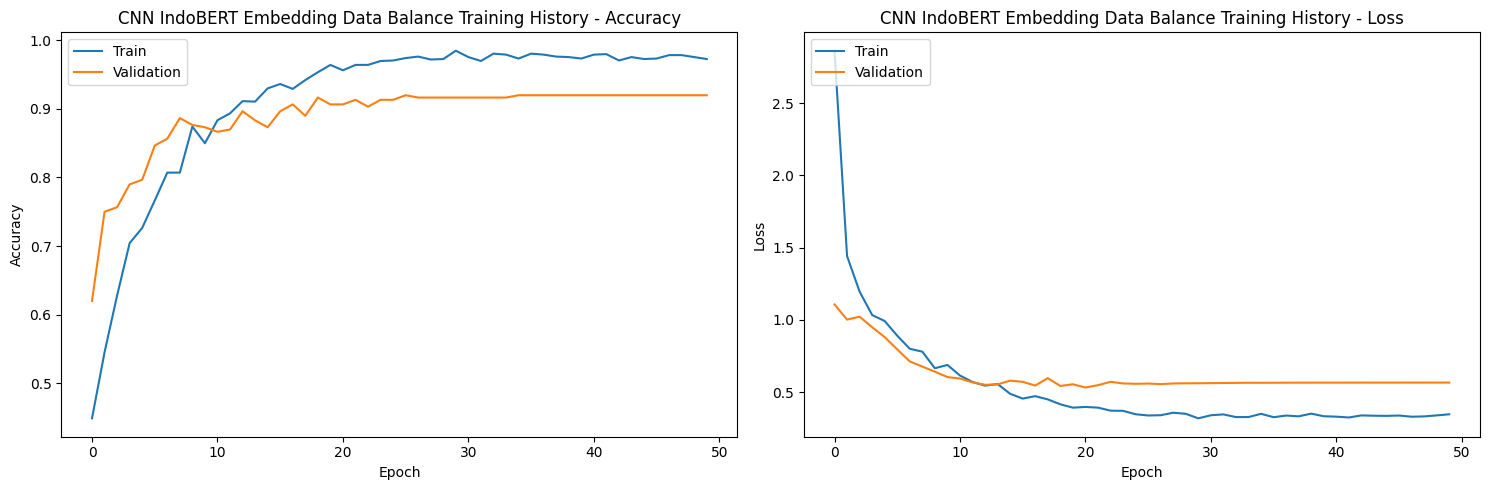

In [89]:
plot_history(cnn_history, 'CNN IndoBERT Embedding Data Balance Training History')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

Classification Report - CNN IndoBERT Embedding Model Data Balance:
              precision    recall  f1-score   support

     Neutral       0.85      0.89      0.87        94
    Positive       0.97      0.89      0.93        99
    Negative       0.92      0.94      0.93       107

    accuracy                           0.91       300
   macro avg       0.91      0.91      0.91       300
weighted avg       0.91      0.91      0.91       300

F1 Score (weighted): 0.9104
F1 Score (macro)   : 0.9092


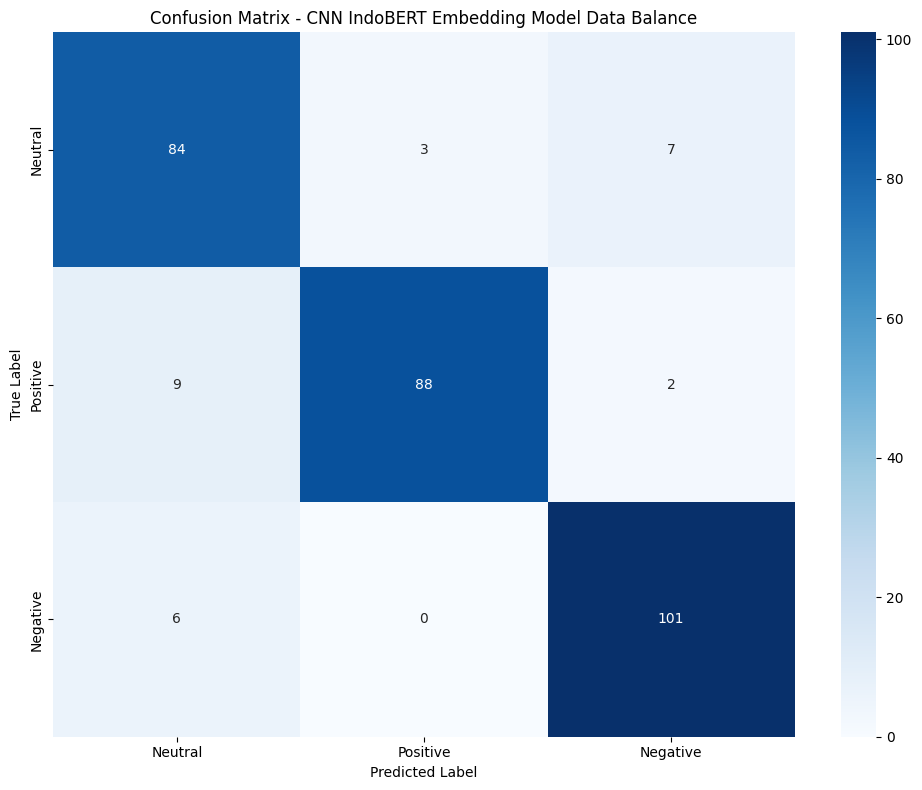

Saved predictions to Excel: CNN_Model_IndoBERT_Data_Balance_predictions.xlsx


In [65]:
# Evaluasi model
results_cnn = evaluate_model(
    model       = cnn_model,
    X_input     = X_test_input,
    y_test      = y_test,
    y_test_cat  = y_test_cat,
    model_name  = "CNN IndoBERT Embedding Model Data Balance",
    classes     = sentiment_classes
)

y_pred = results_cnn['y_pred']
y_true = np.argmax(y_test_cat, axis=1)

# Pastikan X_test_texts jadi Pandas Series
X_test_series = X_test_texts if isinstance(X_test_texts, pd.Series) else pd.Series(X_test_texts)

# Simpan prediksi
df_preds = save_predictions(
    raw_texts  = X_test_series,
    y_true     = y_true,
    y_pred     = y_pred,
    model_name = 'CNN_Model_IndoBERT_Data_Balance'
)

## CNN - LSTM

In [38]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, BatchNormalization, GlobalMaxPooling1D, RepeatVector, LSTM, Dropout, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score

In [66]:
# Parameter
X_train_input = X_train_embed      # shape: (n, seq_len, embed_dim)
X_val_input   = X_val_embed
X_test_input  = X_test_embed

# Ambil dimensi seq_len dan embed_dim dari data
seq_len   = X_train_input.shape[1]  # misal 128
embed_dim = X_train_input.shape[2]  # misal 1024

# One-hot encode labels
y_train_cat = to_categorical(y_train)
y_val_cat   = to_categorical(y_val)
y_test_cat  = to_categorical(y_test)

num_classes  = y_train_cat.shape[1]
lstm_units   = 64
dropout_rate = 0.5

In [79]:
# early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

checkpoint = ModelCheckpoint(
    'best_cnn_lstm_indobert_balance.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)
callbacks = [checkpoint, reduce_lr]

# CNN Model
input_layer = Input(shape=(seq_len, embed_dim), name='input_emb')

# CNN part (identical structure)
x = Conv1D(64, 1, activation='relu', kernel_regularizer=l2(0.001))(input_layer)
x = BatchNormalization()(x)
x = GlobalMaxPooling1D()(x)

# Convert to sequence length=1
x = RepeatVector(1)(x)

# LSTM part
x = LSTM(lstm_units, kernel_regularizer=l2(0.01))(x)

# Head
x = Dropout(dropout_rate)(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(dropout_rate)(x)
output = Dense(num_classes, activation='softmax')(x)

cnnlstm_model = Model(inputs=input_layer, outputs=output)
cnnlstm_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
cnnlstm_model.summary()

# Train
cnnlstm_history = cnnlstm_model.fit(
    X_train_input, y_train_cat,
    validation_data=(X_val_input, y_val_cat),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# Load best weights & save architecture
cnnlstm_model.load_weights('best_cnn_lstm_indobert_balance.weights.h5')
with open('best_architecture_cnn_lstm_indobert_balance.json', 'w') as f:
    f.write(cnnlstm_model.to_json())
print("Model berhasil disimpan")

# Evaluate
val_proba = cnnlstm_model.predict(X_val_input)
val_pred  = np.argmax(val_proba, axis=1)
val_true  = np.argmax(y_val_cat, axis=1)

print("Validation F1 (weighted):", f1_score(val_true, val_pred, average='weighted'))
print("Validation F1 (macro)   :", f1_score(val_true, val_pred, average='macro'))


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_emb (InputLayer)          │ (None, 128, 1024)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 128, 64)        │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 128, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_13         │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_10 (RepeatVector) │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,059 (394.76 KB)

 Trainable params: 100,931 (394.26 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/50
42/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4176 - loss: 2.4972
Epoch 1: val_loss improved from inf to 1.82466, saving model to best_cnn_lstm_indobert_balance.weights.h5
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.4229 - loss: 2.4828 - val_accuracy: 0.8000 - val_loss: 1.8247 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6975 - loss: 1.6898
Epoch 2: val_loss improved from 1.82466 to 1.31431, saving model to best_cnn_lstm_indobert_balance.weights.h5
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6983 - loss: 1.6869 - val_accuracy: 0.8000 - val_loss: 1.3143 - learning_rate: 0.0010
Epoch 3/50
40/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8372 - loss: 1.2111
Epoch 3: val_loss improved from 1.31431 to 0.97184, saving model to best_cnn_lstm_indobert_balance.weights.h5
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8401 - loss: 1.1996 - val_accuracy: 0.8833 - val_loss: 0.9718 - learning_rate: 0.0010
Ep

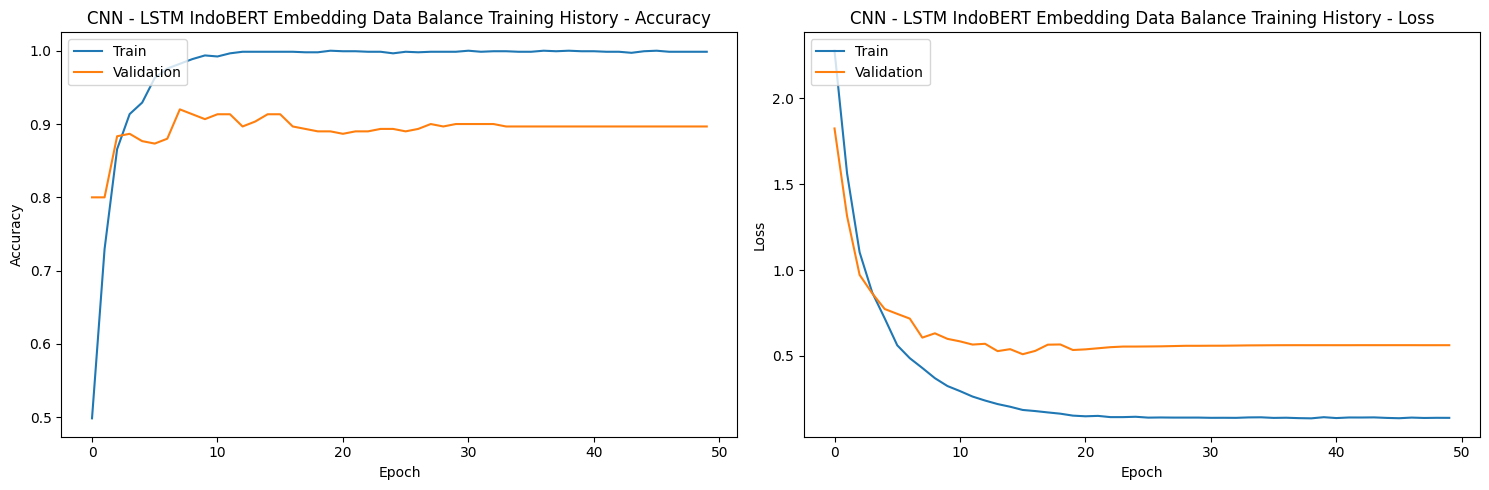

In [80]:
plot_history(cnnlstm_history, 'CNN - LSTM IndoBERT Embedding Data Balance Training History')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

Classification Report - CNN-LSTM IndoBERT Embedding Model Data Balance:
              precision    recall  f1-score   support

     Neutral       0.90      0.87      0.89        94
    Positive       0.94      0.92      0.93        99
    Negative       0.92      0.96      0.94       107

    accuracy                           0.92       300
   macro avg       0.92      0.92      0.92       300
weighted avg       0.92      0.92      0.92       300

F1 Score (weighted): 0.9197
F1 Score (macro)   : 0.9186


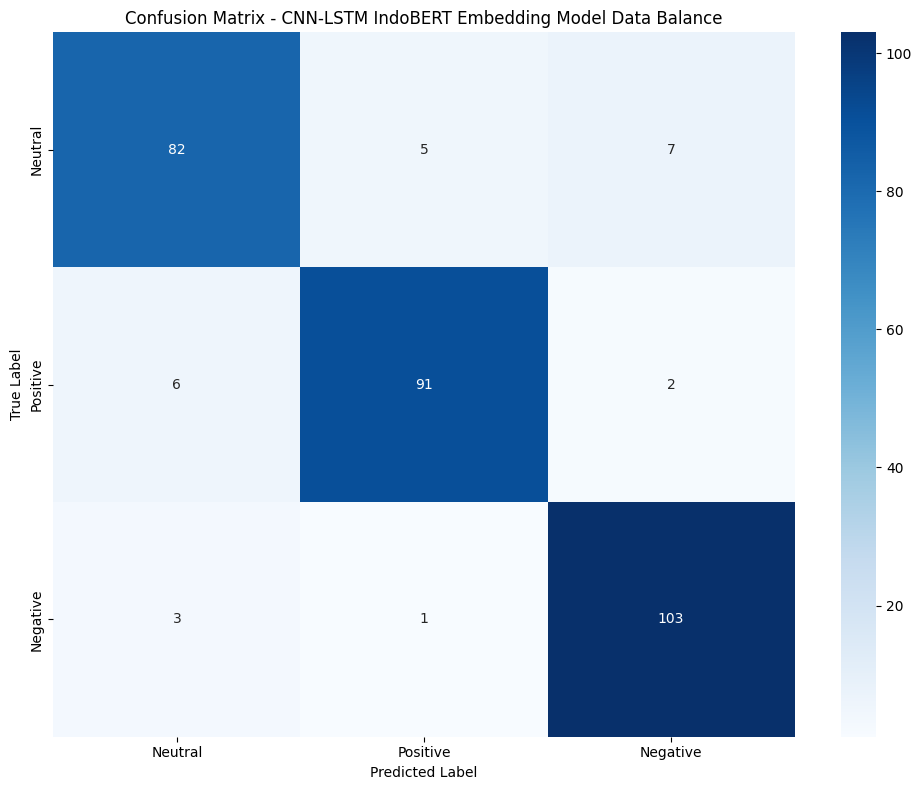

Saved predictions to Excel: CNN-LSTM_Model_IndoBERT_Data_Balance_predictions.xlsx


In [81]:
# Evaluasi model
results_cnnlstm = evaluate_model(
    model       = cnnlstm_model,
    X_input     = X_test_input,
    y_test      = y_test,
    y_test_cat  = y_test_cat,
    model_name  = "CNN-LSTM IndoBERT Embedding Model Data Balance",
    classes     = sentiment_classes
)

y_pred = results_cnnlstm['y_pred']
y_true = np.argmax(y_test_cat, axis=1)

# Pastikan X_test_texts jadi Pandas Series
X_test_series = X_test_texts if isinstance(X_test_texts, pd.Series) else pd.Series(X_test_texts)

# Simpan prediksi
df_preds = save_predictions(
    raw_texts  = X_test_series,
    y_true     = y_true,
    y_pred     = y_pred,
    model_name = 'CNN-LSTM_Model_IndoBERT_Data_Balance'
)

## CNN - BiLSTM

In [35]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Embedding, Conv1D, BatchNormalization,
    GlobalMaxPooling1D, RepeatVector,
    Bidirectional, LSTM, Dropout, Dense
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score

In [44]:
# Parameter
X_train_input = X_train_embed      # shape: (n, seq_len, embed_dim)
X_val_input   = X_val_embed
X_test_input  = X_test_embed

# Ambil dimensi seq_len dan embed_dim dari data
seq_len   = X_train_input.shape[1]  # misal 128
embed_dim = X_train_input.shape[2]  # misal 1024

# One-hot encode labels
y_train_cat = to_categorical(y_train)
y_val_cat   = to_categorical(y_val)
y_test_cat  = to_categorical(y_test)

num_classes  = y_train_cat.shape[1]
lstm_units   = 64
dropout_rate = 0.5

In [45]:
checkpoint = ModelCheckpoint(
    'best_cnn_bilstm_indobert_balance.weights.h5',
    monitor='val_loss', save_best_only=True,
    save_weights_only=True, verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5,
    patience=2, min_lr=1e-6, verbose=1
)
callbacks = [checkpoint, reduce_lr]

# Model CNN
input_layer = Input(shape=(seq_len, embed_dim), name='input_emb')

# CNN part: 1-gram filter
x = Conv1D(filters=64, kernel_size=1, activation='relu', kernel_regularizer=l2(0.001))(input_layer)
x = BatchNormalization()(x)
x = GlobalMaxPooling1D()(x)  # -> (batch, 64)

# Ubah ke sequence length=1 agar BiLSTM bisa konsumsi
x = RepeatVector(1)(x)       # -> (batch, 1, 64)

# BiLSTM part
x = Bidirectional(LSTM(lstm_units, kernel_regularizer=l2(0.001)))(x)

# Head
x = Dropout(dropout_rate)(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(dropout_rate)(x)
output = Dense(num_classes, activation='softmax')(x)

cnnbilstm_model = Model(inputs=input_layer, outputs=output)
cnnbilstm_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
cnnbilstm_model.summary()

# Train
cnnbilstm_history = cnnbilstm_model.fit(
    X_train_input, y_train_cat,
    validation_data=(X_val_input, y_val_cat),
    epochs=50, batch_size=32,
    callbacks=callbacks, verbose=1
)

# Load best weights & save architecture
cnnbilstm_model.load_weights('best_cnn_bilstm_indobert_balance.weights.h5')
with open('best_architecture_cnn_bilstm_indobert_balance.json', 'w') as f:
    f.write(cnnbilstm_model.to_json())
print("Model telah disimpan")

# Evaluate
val_proba = cnnbilstm_model.predict(X_val_input)
val_pred  = np.argmax(val_proba, axis=1)
val_true  = np.argmax(y_val_cat, axis=1)

print("Validation F1 (weighted):", f1_score(val_true, val_pred, average='weighted'))
print("Validation F1 (macro):   ", f1_score(val_true, val_pred, average='macro'))

# Jika perlu menyimpan full model:
# cnnbilstm_model.save('cnn_bilstm_indobert_model.h5')

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_emb (InputLayer)          │ (None, 128, 1024)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 128, 64)        │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,131 (531.76 KB)

 Trainable params: 136,003 (531.26 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/50
42/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4373 - loss: 1.4171
Epoch 1: val_loss improved from inf to 1.13172, saving model to best_cnn_bilstm_indobert_balance.weights.h5
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.4417 - loss: 1.4110 - val_accuracy: 0.7367 - val_loss: 1.1317 - learning_rate: 0.0010
Epoch 2/50
42/44 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7086 - loss: 1.0323
Epoch 2: val_loss improved from 1.13172 to 0.90160, saving model to best_cnn_bilstm_indobert_balance.weights.h5
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7118 - loss: 1.0264 - val_accuracy: 0.7767 - val_loss: 0.9016 - learning_rate: 0.0010
Epoch 3/50
40/44 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8423 - loss: 0.7411 
Epoch 3: val_loss improved from 0.90160 to 0.71900, saving model to best_cnn_bilstm_indobert_balance.weights.h5
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8446 - loss: 0.7355 - val_accuracy: 0.8433 - val_loss: 0.7190 - learning_rate: 0

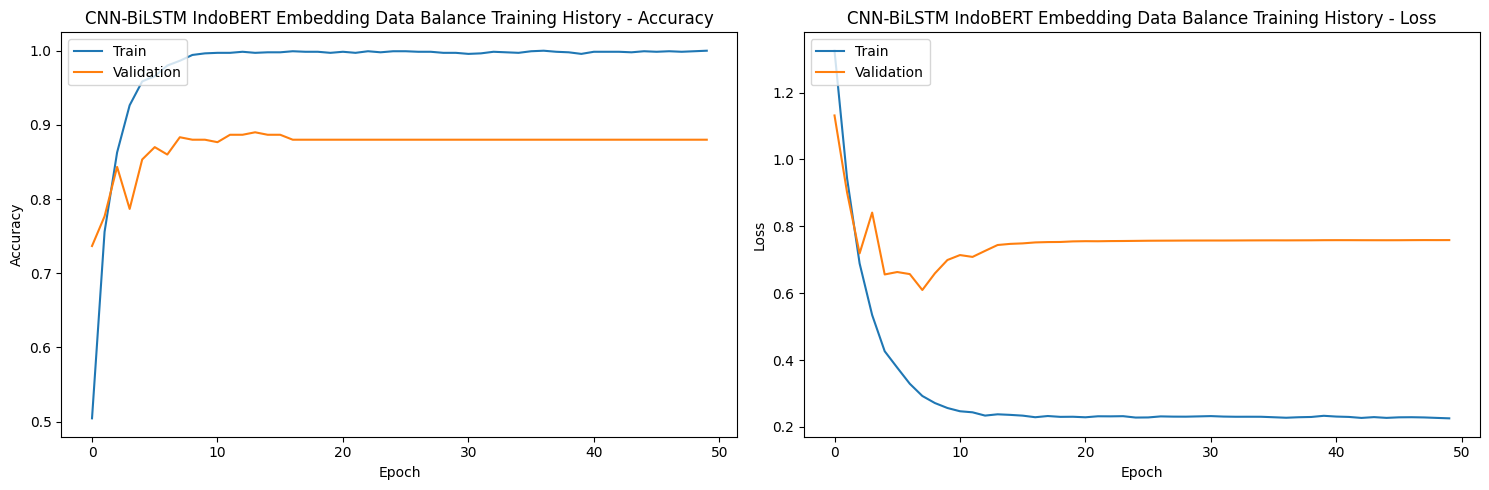

In [46]:
plot_history(cnnbilstm_history, 'CNN-BiLSTM IndoBERT Embedding Data Balance Training History')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Classification Report - CNN-BiLSTM IndoBERT Embedding Model Data Balance:
              precision    recall  f1-score   support

     Neutral       0.91      0.82      0.86        94
    Positive       0.91      0.90      0.90        99
    Negative       0.90      0.98      0.94       107

    accuracy                           0.90       300
   macro avg       0.90      0.90      0.90       300
weighted avg       0.90      0.90      0.90       300

F1 Score (weighted): 0.9021
F1 Score (macro)   : 0.9005


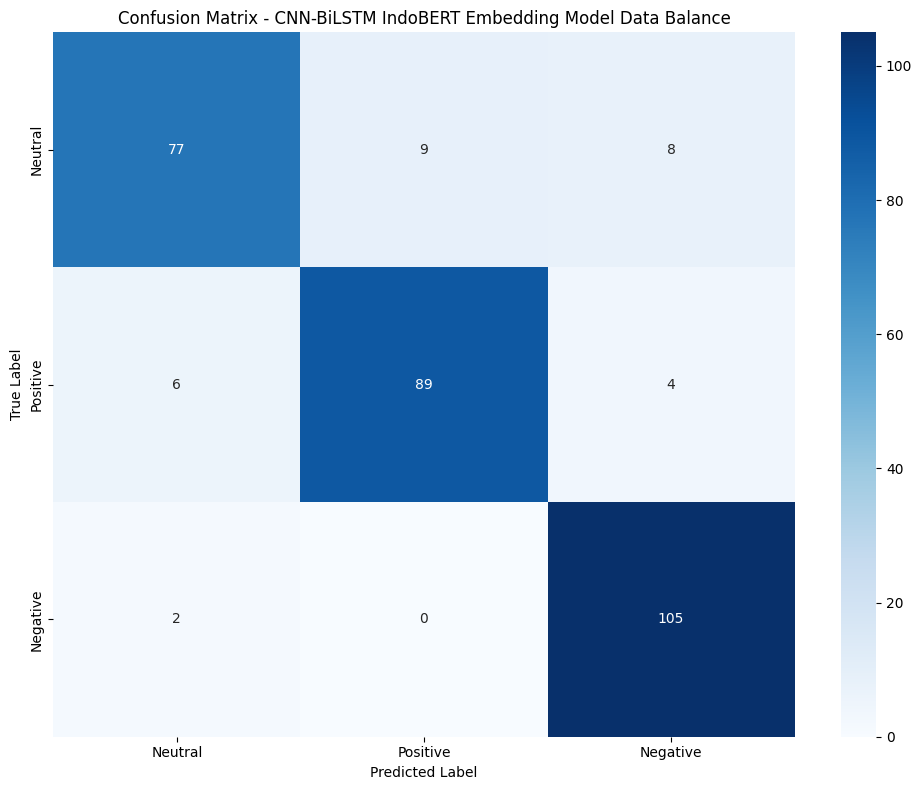

Saved predictions to Excel: CNN-BiLSTM_Model_IndoBERT_Data_Balance_predictions.xlsx


In [39]:
# Evaluasi model
results_cnnbilstm = evaluate_model(
    model       = cnnbilstm_model,
    X_input     = X_test_input,
    y_test      = y_test,
    y_test_cat  = y_test_cat,
    model_name  = "CNN-BiLSTM IndoBERT Embedding Model Data Balance",
    classes     = sentiment_classes
)

y_pred = results_cnnbilstm['y_pred']
y_true = np.argmax(y_test_cat, axis=1)

# Pastikan X_test_texts jadi Pandas Series
X_test_series = X_test_texts if isinstance(X_test_texts, pd.Series) else pd.Series(X_test_texts)

# Simpan prediksi
df_preds = save_predictions(
    raw_texts  = X_test_series,
    y_true     = y_true,
    y_pred     = y_pred,
    model_name = 'CNN-BiLSTM_Model_IndoBERT_Data_Balance'
)